In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyarrow.parquet as pq
import gc
import pywt
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter
from tqdm import tqdm_notebook
import os
from multiprocessing import Pool

from numba import jit

import warnings

# Suppress pandas future warnings, I am using different library versions locally
# that do not raise warnings.
warnings.simplefilter(action='ignore', category=FutureWarning)

data_dir = '../input'

In [2]:
print(scipy.__version__)

1.1.0


In [3]:
# 800,000 data points taken over 20 ms
# Grid operates at 50hz, 0.02 * 50 = 1, so 800k samples in 20 milliseconds will capture one complete cycle
n_samples = 800000

# Sample duration is 20 miliseconds
sample_duration = 0.02

# Sample rate is the number of samples in one second
# Sample rate will be 40mhz
sample_rate = n_samples * (1 / sample_duration)

In [4]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [5]:
def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    # scipy version 1.2.0
    #sos = butter(10, low_freq, btype='hp', fs=sample_fs, output='sos')
    
    # scipy version 1.1.0
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

In [6]:
def denoise_signal( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff[1:], wavelet, mode='per' )

In [7]:
def denoise_signal_2( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff[0:], wavelet, mode='per' )

In [8]:
def remove_corona(x_dn):
    index = pd.Series(x_dn).loc[np.abs(x_dn)>0].index
    corona_idx = []
    for idx in index:
        for i in range(1,maxDistance+1):
            if idx+i < pd.Series(x_dn).shape[0]:
                if x_dn[idx+i]/(x_dn[idx]+1e-04)<-maxHeightRatio:
                    x_dn[idx:idx+maxTicksRemoval] = 0
                    corona_idx.append(idx)
    return x_dn, corona_idx

In [9]:
@jit
def main(x):
    for col in tqdm_notebook(range(x.shape[1])):
        x_hp = high_pass_filter(x.iloc[:,col], low_cutoff=10000, sample_rate=sample_rate)
        x_dn = denoise_signal(x_hp, wavelet='haar', level=1)
        x_dn_2 = denoise_signal_2(x_hp, wavelet='haar', level=1)

        x_dn, corona_idx = remove_corona(x_dn) 
        
        x_dn_len = len(x_dn)
        x_dn_2_len = np.int(len(x_dn_2)/4)
        
        corona_idx = np.array(corona_idx)*2
        
        for idx in corona_idx:
            x_dn_2[idx:idx+maxTicksRemoval] = 500
                
        stdampall_ad.append(np.std(x_dn_2))
        stdampq2_ad.append(np.std(x_dn_2[x_dn_2_len+1 : 2*x_dn_2_len]))
        stdampq3_ad.append(np.std(x_dn_2[(2*x_dn_2_len)+1:3*x_dn_2_len]))
        stdampq4_ad.append(np.std(x_dn_2[(3*x_dn_2_len)+1:4*x_dn_2_len]))
        
        meanampall_ad.append(np.mean(x_dn_2))
        meanampq2_ad.append(np.mean(x_dn_2[x_dn_2_len+1 : 2*x_dn_2_len]))
        meanampq3_ad.append(np.mean(x_dn_2[(2*x_dn_2_len)+1:3*x_dn_2_len]))
        meanampq4_ad.append(np.mean(x_dn_2[(3*x_dn_2_len)+1:4*x_dn_2_len]))
                        
        meanamppos.append(np.mean(pd.Series(x_dn).loc[x_dn>0]))
        meanampneg.append(np.mean(pd.Series(x_dn).loc[x_dn<0]))

In [10]:
stdampall_ad = []
stdampq2_ad = []
stdampq3_ad = []
stdampq4_ad = []

meanampall_ad = []
meanampq2_ad = []
meanampq3_ad = []
meanampq4_ad = []

meanamppos = []
meanampneg = []

In [11]:
maxDistance = 10
maxHeightRatio = 0.25
maxTicksRemoval =500

In [12]:
subset_train = pq.read_pandas(data_dir + '/train.parquet', columns=[str(i) for i in range(1017, 1035)]).to_pandas()

In [13]:
plt.plot(subset_train['0']+subset_train['1']+subset_train['2'])

KeyError: '0'

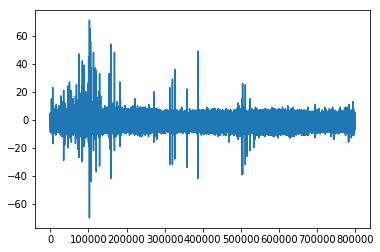

In [49]:
plt.plot(subset_train['3']+subset_train['4']+subset_train['5'])

In [14]:
subset_train.shape[1]

18

In [15]:
X_HP = []
X_DN = []
X_DN_2 = []

for col in range(subset_train.shape[1]):
    X_HP.append(high_pass_filter(subset_train.iloc[:,col], low_cutoff=10000, sample_rate=sample_rate))
    
    X_DN.append(denoise_signal(X_HP[col], wavelet='haar', level=1))
    X_DN_2.append(denoise_signal(X_HP[col], wavelet='haar', level=1))

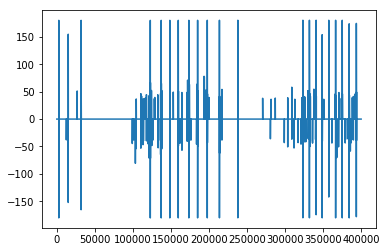

In [16]:
plt.plot(X_DN[0])

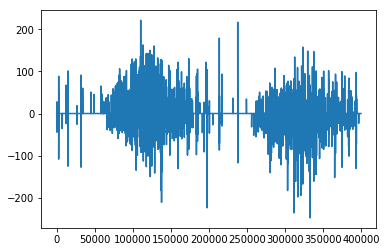

In [17]:
plt.plot(X_DN[0]+X_DN[1]+X_DN[2])

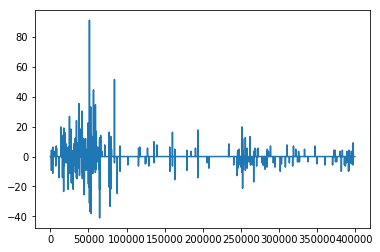

In [55]:
plt.plot(X_DN[3])

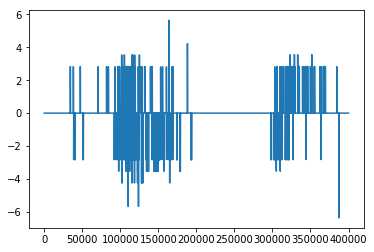

In [18]:
plt.plot(X_DN[3]+X_DN[4]+X_DN[5])

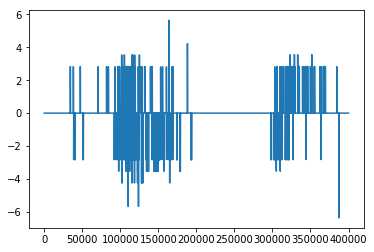

In [19]:
plt.plot(X_DN_2[3]+X_DN_2[4]+X_DN_2[5])

In [20]:
for col in range(subset_train.shape[1]):    
    X_DN[col], corona_idx = remove_corona(X_DN[col])

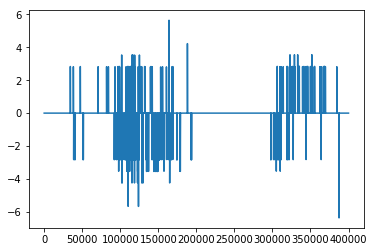

In [21]:
plt.plot(X_DN[3]+X_DN[4]+X_DN[5])

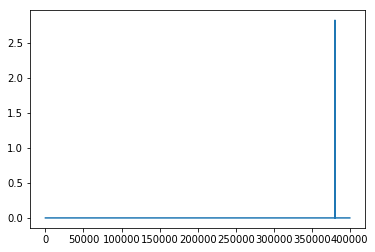

In [27]:
plt.plot(X_DN[6]+X_DN[7]+X_DN[8])

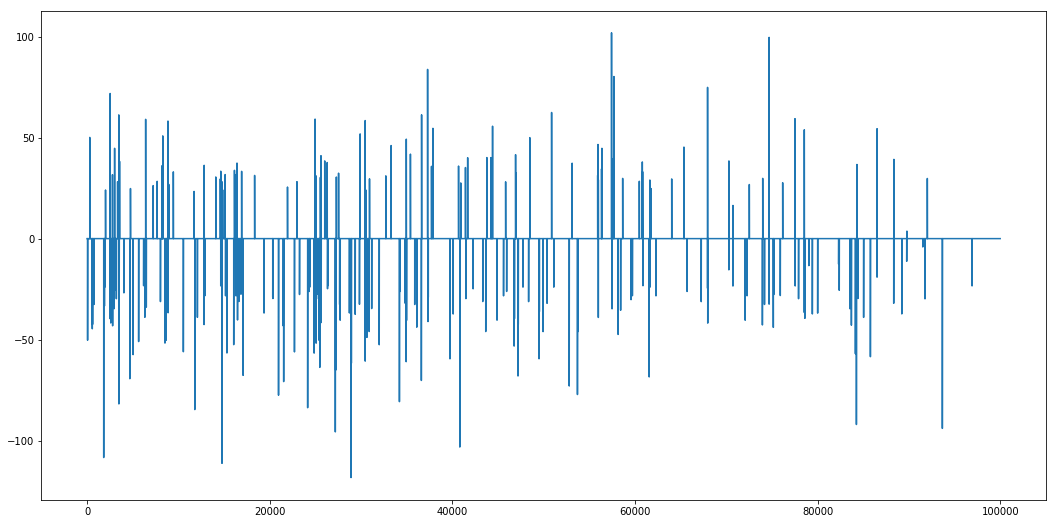

In [63]:
plt.figure(figsize=(18, 9))
plt.plot((X_DN[0]+X_DN[1]+X_DN[2])[300000:400000])

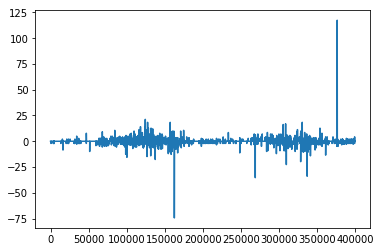

In [65]:
plt.plot(X_DN[9]+X_DN[10]+X_DN[11])

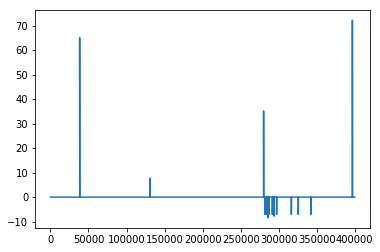

In [25]:
plt.plot(X_DN[12]+X_DN[13]+X_DN[14])

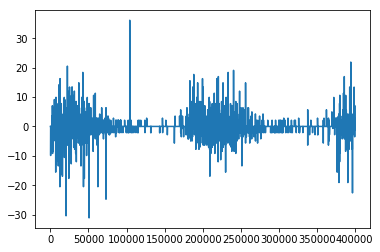

In [26]:
plt.plot(X_DN[15]+X_DN[16]+X_DN[17])

In [52]:
total = X_DN[3]+X_DN[4]+X_DN[5]

In [67]:
total = pd.Series(total)
total[total>0].count()

84

In [54]:
np.mean(total[total<0])

-3.1382261364440716

In [55]:
np.mean(total[total>0])

2.954436243056111

In [56]:
np.max(total)

5.646588411884294

In [57]:
np.min(total)

-6.371335221821432

In [ ]:
x_hp = high_pass_filter(x.iloc[:,col], low_cutoff=10000, sample_rate=sample_rate)
x_dn = denoise_signal(x_hp, wavelet='haar', level=1)
x_dn_2 = denoise_signal_2(x_hp, wavelet='haar', level=1)

In [15]:
stdampall_ad = np.array(stdampall_ad)
stdampq2_ad = np.array(stdampq2_ad)
stdampq3_ad = np.array(stdampq3_ad)
stdampq4_ad = np.array(stdampq4_ad)

meanampall_ad = np.array(meanampall_ad)
meanampq2_ad = np.array(meanampq2_ad)
meanampq3_ad = np.array(meanampq3_ad)
meanampq4_ad = np.array(meanampq4_ad)

meanamppos = np.array(meanamppos)
meanampneg = np.array(meanampneg)

In [16]:
np.save('../features/stdampall_ad.npy', stdampall_ad)
np.save('../features/stdampq2_ad.npy', stdampq2_ad)
np.save('../features/stdampq3_ad.npy', stdampq3_ad)
np.save('../features/stdampq4_ad.npy', stdampq4_ad)
np.save('../features/meanampall_ad.npy', meanampall_ad)
np.save('../features/meanampq2_ad.npy', meanampq2_ad)
np.save('../features/meanampq3_ad.npy', meanampq3_ad)
np.save('../features/meanampq4_ad.npy', meanampq4_ad)
np.save('../features/meanamppos.npy', meanamppos)
np.save('../features/meanampneg.npy', meanampneg)

In [ ]:
for i in range(10):
    subset_test = pq.read_pandas('../input/test.parquet', columns=[str(i*2000 + j + 8712) for j in range(2000)]).to_pandas()
    numpeaks_stack += main(subset_test)
    gc.collect()

In [ ]:
len(numpeaks_stack)

In [ ]:
numpeaks = np.array(numpeaks_stack)
numpospeaks = np.array(numpospeaks)
numnegpeaks = np.array(numnegpeaks)

maxpeakwidth = np.array(maxpeakwidth)
minpeakwidth = np.array(minpeakwidth)
meanpeakwidth = np.array(meanpeakwidth)
maxamp = np.array(maxamp)
minamp = np.array(minamp)
meanamp = np.array(meanamp)

stdampall = np.array(stdampall)
stdposall = np.array(stdposall)
stdwidthall = np.array(stdwidthall)

stdampq2 = np.array(stdampq2)
stdposq2 = np.array(stdposq2)
stdwidthq2 = np.array(stdwidthq2)
stdampq3 = np.array(stdampq3)
stdposq3 = np.array(stdposq3)
stdwidthq3 = np.array(stdwidthq3)
stdampq4 = np.array(stdampq4)
stdposq4 = np.array(stdposq4)
stdwidthq4 = np.array(stdwidthq4)

In [ ]:
np.save('../features/numpeaks_test.npy', numpeaks)
np.save('../features/numpospeaks_test.npy', numpospeaks)
np.save('../features/numnegpeaks_test.npy', numnegpeaks)
np.save('../features/maxpeakwidth_test.npy', maxpeakwidth)
np.save('../features/minpeakwidth_test.npy', minpeakwidth)
np.save('../features/meanpeakwidth_test.npy', meanpeakwidth)
np.save('../features/maxamp_test.npy', maxamp)
np.save('../features/minamp_test.npy', minamp)
np.save('../features/meanamp_test.npy', meanamp)
np.save('../features/stdampall_test.npy', stdampall)
np.save('../features/stdposall_test.npy', stdposall)
np.save('../features/stdwidthall_test.npy', stdwidthall)
np.save('../features/stdampq2_test.npy', stdampq2)
np.save('../features/stdposq2_test.npy', stdposq2)
np.save('../features/stdwidthq2_test.npy', stdwidthq2)
np.save('../features/stdampq3_test.npy', stdampq3)
np.save('../features/stdposq3_test.npy', stdposq3)
np.save('../features/stdwidthq3_test.npy', stdwidthq3)
np.save('../features/stdampq4_test.npy', stdampq4)
np.save('../features/stdposq4_test.npy', stdposq4)
np.save('../features/stdwidthq4_test.npy', stdwidthq4)